In [1]:
import torch
import torch.optim as optim
import torch.cuda as cuda
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from os.path import exists
from Dataset import FramesDataset
import pandas as pd
#from UNET import UNET
from resNet import resNet
#from convNet import convNet

In [2]:
BATCH = 2
EPOCHS = 20
LR = 0.00146
cuda.empty_cache()
device = "cuda" if cuda.is_available() else "cpu"
dir_dataset = r'C:\Users\Mau\Desktop\proyectos\Proyecto\test_2k_540p'
#dir_dataset = r'C:\Users\Mau\Desktop\proyectos\Proyecto\dataset'
dataset = FramesDataset(dir = dir_dataset, transform=transforms.ToTensor())
#model = UNET(in_channels=6, out_channels=3).to(device)
#model = convNet(6,3).to(device)
model = resNet(6,3).to(device)

In [3]:
if(exists("./weights/resNet.pth")):
  model.load_state_dict(torch.load('./weights/resNet.pth'))

In [4]:
length = dataset.__len__()
test = length//10
train = length - test
trainset, testset = random_split(dataset,[train,test])
trainset = DataLoader(trainset, batch_size=BATCH, shuffle=True, pin_memory=True,num_workers=2)
testset = DataLoader(testset, batch_size=1, shuffle=True)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
lossFunction = torch.nn.MSELoss(reduction='mean')
totalLoss = []
for epoch in range(EPOCHS):
    epochLoss = []
    for data in trainset:
        (F1,F3) ,F2, (img1, img3) = data 
        input = torch.cat([F1.to(device), F3.to(device)], dim=1)
        output = model(input)
        loss  = lossFunction(output , F2.to(device))
        epochLoss.append(loss.item())
        loss.backward()
        optimizer. step()
        optimizer.zero_grad()
        del F1, F2, F3, loss, output,  img1, data
    print(sum(epochLoss)/len(epochLoss))
    totalLoss.append(sum(epochLoss)/len(epochLoss))

In [8]:
data = []
data = next(iter(testset))
((F1,F3) ,F2, (img1, img3)) = data
cuda.reset_peak_memory_stats(device="cuda")
with torch.no_grad():
    output = model(torch.cat([F1.to(device), F3.to(device)], dim=1))
img1 = F1.numpy()[0].transpose(1,2,0)
img2 = F2.cpu().numpy()[0].transpose(1,2,0)
img3 = F3.numpy()[0].transpose(1,2,0)
generated = output.cpu().detach().numpy()[0].transpose(1,2,0)
del F1, F2, F3, output, data
cuda.reset_peak_memory_stats(device="cuda")

[[[0.15138242 0.17533424 0.1620255 ]
  [0.10320926 0.0904638  0.10416277]
  [0.09530723 0.07834773 0.09930976]
  ...
  [0.05020356 0.05088922 0.07421188]
  [0.06127656 0.06080393 0.09017336]
  [0.15340135 0.14760725 0.15646128]]

 [[0.11042166 0.08955932 0.09915762]
  [0.06457011 0.0468049  0.05166765]
  [0.0652024  0.04513749 0.05456619]
  ...
  [0.00427119 0.01826572 0.03372511]
  [0.0184203  0.0333285  0.04489462]
  [0.09524234 0.0960881  0.11605048]]

 [[0.0813251  0.06133084 0.06373239]
  [0.03712146 0.01303101 0.01534677]
  [0.04687047 0.01359522 0.0285027 ]
  ...
  [0.02085805 0.01562854 0.0289251 ]
  [0.02349254 0.0230519  0.04421846]
  [0.09827594 0.08348259 0.10174286]]

 ...

 [[0.05863659 0.03424792 0.03320324]
  [0.00572892 0.         0.        ]
  [0.02410706 0.00635207 0.00301949]
  ...
  [0.02766148 0.04181826 0.02664975]
  [0.01917223 0.03057349 0.00854381]
  [0.07854291 0.07602859 0.06669295]]

 [[0.06225523 0.04135863 0.04595689]
  [0.0240223  0.00189157 0.        ]


Text(0.5, 1.0, 'generated')

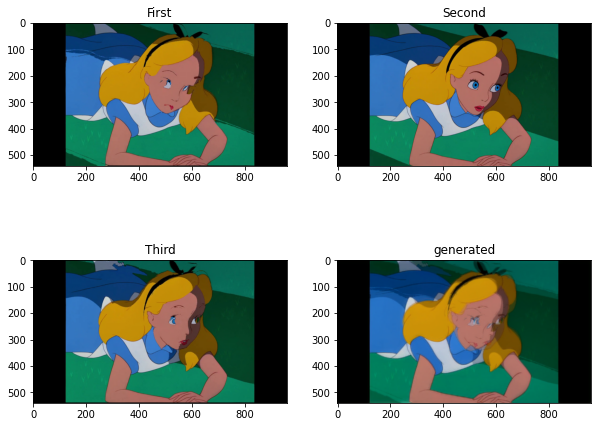

In [9]:
print(generated)
fig = plt.figure(figsize=(10, 8))
fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
plt.title("First")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Second")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Third")
fig.add_subplot(2, 2, 4)
plt.imshow(generated)
plt.title("generated")

In [7]:
#arr = np.asarray(totalLoss)
#DF = pd.DataFrame(arr)
#DF.to_csv("grdnet.csv") 
#torch.save(model.state_dict(), './weights/grdnet.pth')